# **Task.**
Encode a program that takes a graph as input and return a minimum vertex cover of it.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import time
from math import ceil
%matplotlib inline

In [ ]:
G = nx.random_graphs.fast_gnp_random_graph(50,.5)

In [ ]:
G.number_of_nodes()

50

In [ ]:
G.number_of_edges()

616

# Algorithm to find minimum vertex cover of a graph

### Difinitions

For every ***vertex*** of initial graph consider a flag ***is_selected***, that is 1 (True), if it is in vertex cover(***vc***), otherwise 0 (False). Notice that if vertex is not selected then all its nieghbours are in vc.

***cur_G*** - the current graph that remained after removing explored nodes.

***frontier*** - the list of candiadate vertices for a subproblem. Each entry is a tuple (vertex, is_selected of vertex, (parent vertex in searching tree, is_selected of parent vertex)).

***cur_vc*** -  current vc found in particular step of search.

***min_vc*** - vc with minimum value of *|cur_vc|* at any given step of search.

**upper_bound** - initially the number of vertices in cur_G, that will be decreasing to the size of the minimum vertex cover during steps of the solution.

**lower_bound**: *|cur_vc| + lower_bound(cur_G)*, where 
*lower_bound(cur_G) = number of edges in cur_G / maximum node degree in cur_G*


### Algorithm

1) Choose vertex v with the maximum degree in cur_G
   This node is stored in the last index of frontier list, and accessed using    frontier.pop()
	 Appened *(v, 1)* and *(v, 0)* to the *cur_vc* as a tuple: *(vertex, is_selected)*

2) If is_selected:
	   Remove the vertex and its edges from cur_G.
	 Else: (not is_selected)
	   Add all neighbors of v to cur_vc and remove v from cur_G, because all its neighbours have to be selected.

3) Consider *cur_G*, if the number of edges is 0, then the possible solution is found (*cur_vc* accounts all edges). 

Check if *|cur_vc*| lesser than *|min_vc|* and update *min_vc* if true, otherwise backtrack to find new path.

Else update *lower_bound*:
If *lower_bound < upper_bound*, continue search and append next maximum degree vertex of *cur_G* to frontier set

Else, there is no better solution in this search space, so can be pruned from *cur_G*. Backtrack to find new path.

4) Backtracking
After reaching the end of a path, we need to **backtrack** to consider a new path. To do this, we have to undo the changes made to *cur_G* and *cur_vc*, which is where the parent item of each tuple in frontier is handy.

If the parent node is in the *vc*, then we remove the last few elements from *cur_vc* that were added after the parent node was discovered and add the corresponing nodes and edges back to *cur_G*.

Elif the parent is (-1,-1) i.e. start of the graph or root node. Reset *cur_G* to *G* and *cur_vc* to empty list.

When frontier is empty, the graph and all possible solutions have been checked

the idea of algorithm is from https://github.com/sangyh/minimum-vertex-cover/blob/master/BnB_Edited.py andT. Akiba and Y. Iwata. Branch-and-reduce exponential/FPT algorithms in practice: A case study of vertex cover. Theoretical Computer Science 609

In [ ]:
# returns the vertex with the maximum degree in graph g

def get_max_deg(g):
  degs = list(g.degree())
  degs.sort(key=lambda x:-x[1])
  v = degs[0]
  return v

In [ ]:
# count lowerbound for graph g

def get_lower_bound(g):
  max_deg = get_maxdeg(g)[1]
  lower_bound = ceil(g.number_of_edges() / max_deg)
  return lower_bound

In [ ]:
# returns size of vertex cover
# vc is a list of tuples, where each tuple = (vertex, is_selected for vertex, (parent vertex, is_selected for parent vertex))

def get_vc_size(vc):
	vc_size = 0
	for element in vc:
		vc_size += element[1]
	return vc_size

In [ ]:
# returns the set of vertecies in vc that are selected

def get_vc_verticies(vc):
  min_vc = []
  for element in vc:
    if element[1] == 1:
      min_vc.append(element[0])
  return min_vc

In [ ]:
# get graph G and maximum time T to find the solution

def get_min_vertex_cover(G, T):
  start_time = time.time()
  end_time = start_time
  times = []  #list of times when solution is found, tuple=(vc_size, delta_time)

  min_vc = []
  cur_vc = []
  frontier = []

  upper_bound = G.number_of_nodes()
  cur_G = G.copy()
  max_v = get_maxdeg(cur_G)[0]

  frontier.append((max_v, 0, (-1, -1)))
  frontier.append((max_v, 1, (-1, -1)))
  neighbor = []
  while len(frontier) and end_time - start_time < T:
    (v, is_selected, parent) = frontier.pop()
    backtrack = False
    if is_selected:
       cur_G.remove_node(v)
    else:
       neighbours = cur_G.neighbors(v)
       for node in list(neighbours):
         cur_vc.append((node, 1))
         cur_G.remove_node(node)
   
    cur_vc.append((v, is_selected))
    cur_vc_size = get_vc_size(cur_vc)
    if cur_G.number_of_edges() == 0:
      if cur_vc_size < upper_bound:
        min_vc = cur_vc.copy()
        upper_bound = cur_vc_size
        times.append((cur_vc_size, time.time() - start_time))
      backtrack = True
    else:
      lower_bound = get_lower_bound(cur_G) + cur_vc_size
      if lower_bound < upper_bound:
        parent_v = v
        v = get_maxdeg(cur_G)[0]
        frontier.append((v, 0, (parent_v, is_selected)))
        frontier.append((v, 1, (parent_v, is_selected)))
      else:
          backtrack = True

    if backtrack:
      if len(frontier):
        next_v_parent = frontier[-1][2]  # parent of the last element in frontier
        if next_v_parent in cur_vc:
          i = cur_vc.index(next_v_parent) + 1
          while i < len(cur_vc):
            v, is_selected = cur_vc.pop()
            cur_G.add_node(v)
            cur_vc_vertices = list(map(lambda t:t[0], cur_vc))
            for u in G.neighbors(v):
              if (u in cur_G.nodes()) and (u not in cur_vc_vertices):
                cur_G.add_edge(u, v)
        elif next_v_parent == (-1, -1):
          cur_G = G.copy()
          cur_vc.clear()
        else:
          print('error during backtracking step')
          end_time = time.time()
    if end_time - start_time > T:
      print('Maximum allowed time reached')
  return min_vc, times

Test function for initial random graph G:

In [ ]:
%%time
vc, times = get_min_vertex_cover(G, 120)
min_vc = get_vc_verticies(vc)
print(f'The size of minimum vertex cover is {len(min_vc)}')
print(f'List of verticies in minimal vertex cover:\n{sorted(min_vc)}')
print(f'time to find vertex covers of size: {times}')

The size of minimum vertex cover is 43
List of verticies in minimal vertex cover:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 49]
time to find vertex covers of size: [(43, 0.010565519332885742)]
CPU times: user 117 ms, sys: 0 ns, total: 117 ms
Wall time: 118 ms


In [ ]:
G = nx.random_graphs.fast_gnp_random_graph(5,.5)

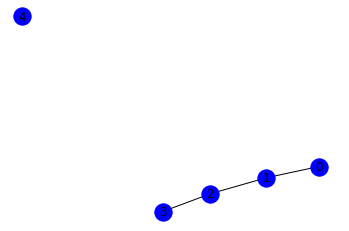

In [ ]:
nx.draw_networkx(G,node_color = 'blue',with_labels = True)
limits=plt.axis('off')  # turn off axis
plt.show()

In [ ]:
%%time
vc, times = get_min_vertex_cover(G, 120)
min_vc = get_vc_verticies(vc)
print(f'The size of minimum vertex cover is {len(min_vc)}')
print(f'List of verticies in minimal vertex cover:\n{sorted(min_vc)}')
print(f'time to find vertex covers of size: {times}')

The size of minimum vertex cover is 2
List of verticies in minimal vertex cover:
[1, 2]
time to find vertex covers of size: [(2, 0.0008292198181152344)]
CPU times: user 719 µs, sys: 0 ns, total: 719 µs
Wall time: 1.34 ms


As we see for graph G vertices [1,2] really form the vertex cover of minimal size.

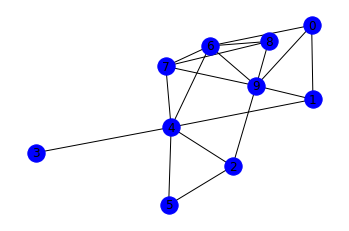

In [ ]:
G = nx.random_graphs.fast_gnp_random_graph(10,.5)
nx.draw_networkx(G,node_color = 'blue',with_labels = True)
limits=plt.axis('off')  # turn off axis
plt.show()

In [ ]:
G.number_of_edges()

18

In [ ]:
%%time
vc, times = get_min_vertex_cover(G, 120)
min_vc = get_vc_verticies(vc)
print(f'The size of minimum vertex cover is {len(min_vc)}')
print(f'List of verticies in minimal vertex cover:\n{sorted(min_vc)}')
print(f'time to find vertex covers of size: {times}')

The size of minimum vertex cover is 6
List of verticies in minimal vertex cover:
[0, 2, 4, 6, 7, 9]
time to find vertex covers of size: [(6, 0.0003285408020019531)]
CPU times: user 3.25 ms, sys: 0 ns, total: 3.25 ms
Wall time: 3.11 ms


It is really vertex cover and we can't find better, because if 9th isn't taken => at least 7, 0, 1, 2, 6, 8 are, and from 3, 4, 5 we have to take at least one => size of vc > 6 => we have to take 9th. 
If 4th isn't taken => 7, 3, 5, 2, 1 also 9th vertex selected, but the edge (6, 0) isn't covered, so |vc| > 6 => we have to take 4 and 9. From any pair (2, 5) , (6,7), (0,1) we have to take at least one vertex if we don't choose 6 => add 8, else if we don't choose 7 then we have to take 8 => |vc| >= 6, Q.E.D.

In general, from the Algorithm description during steps we consider all possible vertex covers and find minimal, it uses Greedy Independent Cover and two local search algorithms including Hill-Climbing and Simulated Annealing and work correctly.

Let's test for specific graphs from nx library:

Node Degree
0 16
1 9
2 10
3 6
4 3
5 4
6 4
7 4
8 5
9 2
10 3
11 1
12 2
13 5
14 2
15 2
16 2
17 2
18 2
19 3
20 2
21 2
22 2
23 5
24 3
25 3
26 2
27 4
28 3
29 4
30 4
31 6
32 12
33 17


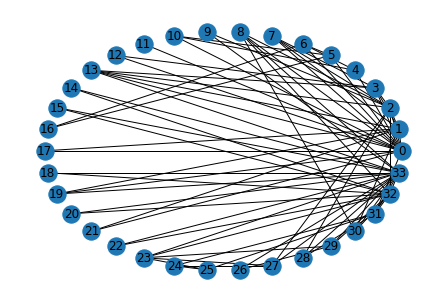

In [ ]:
# Draws circular plot of the network
import matplotlib.pyplot as plt
import networkx as nx

G = nx.karate_club_graph() # data can be read from specified stored social graph in networkx library.
print("Node Degree")
for v in G:
    print (v, G.degree(v))
nx.draw_circular(G, with_labels=True) # different plot layouts possible
plt.show()

In [ ]:
%%time
vc, times = get_min_vertex_cover(G, 120)
min_vc = get_vc_verticies(vc)
print(f'The size of minimum vertex cover is {len(min_vc)}')
print(f'List of verticies in minimal vertex cover:\n{sorted(min_vc)}')
print(f'time to find vertex covers of size: {times}')

The size of minimum vertex cover is 14
List of verticies in minimal vertex cover:
[0, 1, 2, 3, 4, 5, 6, 8, 23, 24, 26, 31, 32, 33]
time to find vertex covers of size: [(14, 0.002794504165649414)]
CPU times: user 9.21 ms, sys: 0 ns, total: 9.21 ms
Wall time: 12.5 ms


it is easy to check that the outputted vertex cover satisfies the solution

In [ ]:
# Returns an approximate minimum weighted vertex cover.
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.vertex_cover.min_weighted_vertex_cover.html
# 22 <= 14 * 2
vc = nx.algorithms.approximation.vertex_cover.min_weighted_vertex_cover(G)
print(vc)
print(len(vc))

{0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 14, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}
22


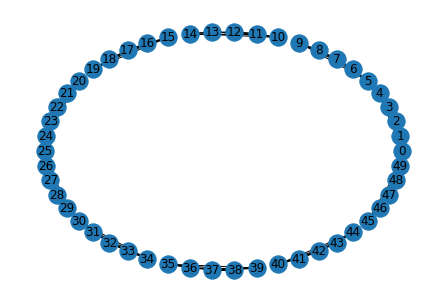

The size of minimum vertex cover is 40
List of verticies in minimal vertex cover:
[0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 32, 33, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48]
time to find vertex covers of size: [(40, 0.006387233734130859)]


In [ ]:
# Draws circular plot of the network
import matplotlib.pyplot as plt
import networkx as nx

G = nx.caveman_graph(10, 5) #	Returns a caveman graph of l cliques of size k.
nx.draw_circular(G, with_labels=True) # different plot layouts possible
plt.show()

vc, times = get_min_vertex_cover(G, 120)
min_vc = get_vc_verticies(vc)
print(f'The size of minimum vertex cover is {len(min_vc)}')
print(f'List of verticies in minimal vertex cover:\n{sorted(min_vc)}')
print(f'time to find vertex covers of size: {times}')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Colab Notebooks/applied graph theory/'

Mounted at /content/drive


In [ ]:
G =nx.read_edgelist(path + 'facebook_combined.txt', create_using = nx.Graph(), nodetype=int)

In [ ]:
G.number_of_edges(), G.number_of_nodes()

(88234, 4039)

[107, 1684, 3437, 1912, 1085]

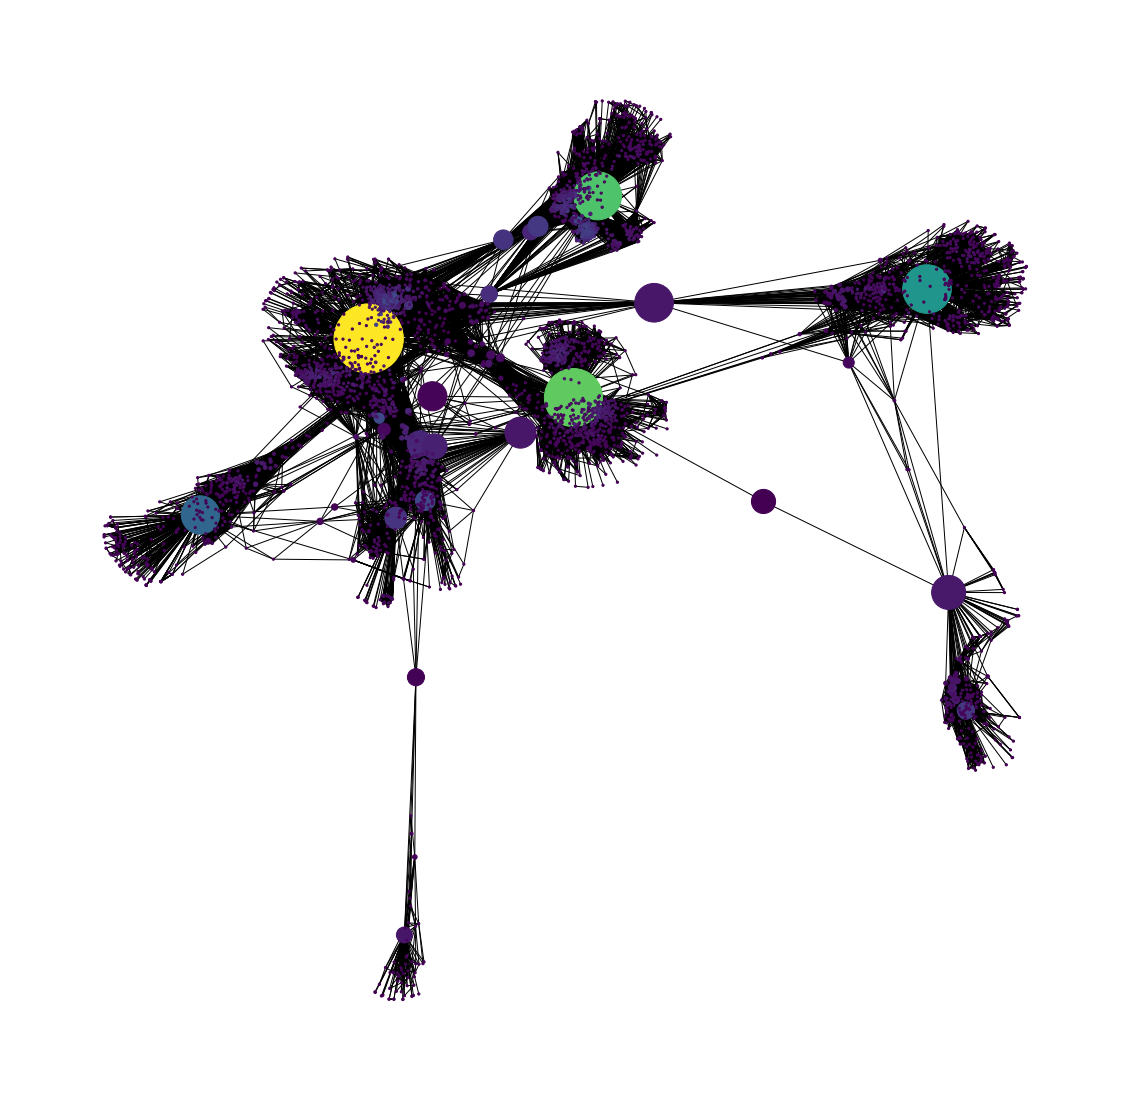

In [ ]:
pos = nx.spring_layout(G)
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
node_color = [20000.0 * G.degree(v) for v in G]
node_size = [v * 10000 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(G, pos=pos, with_labels=False,
node_color=node_color,
node_size=node_size)
plt.axis('off')
sorted(betCent, key=betCent.get, reverse=True)[:5]


In [ ]:
%%time
vc, times = get_min_vertex_cover(G, 120000)
min_vc = get_vc_verticies(vc)
print(f'The size of minimum vertex cover is {len(min_vc)}')
print(f'List of verticies in minimal vertex cover:\n{sorted(min_vc)}')
print(f'time to find vertex covers of size: {times}')